Nenwin-project (NEural Networks WIthout Neurons) for
the AI Honors Academy track 2020-2021 at the TU Eindhoven.

Authors: Lulof Pirée

May 2021

Copyright (C) 2021 Lulof Pirée

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Affero General Public License as published
by the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.

# Banknote dataset with Nenwin

Dataset source: https://code.datasciencedojo.com/datasciencedojo/datasets/blob/master/Banknote%20Authentication/data_banknote_authentication.txt
See also:
* https://jamesmccaffrey.wordpress.com/2020/08/18/in-the-banknote-authentication-dataset-class-0-is-genuine-authentic/
* https://www.researchgate.net/publication/266673146_Banknote_Authentication

This dataset has:
* 1372 samples, of two classes:
    * class 0 (Genuine): 762 samples 
    * class 1 (Forgery): 610 samples

Features:
* 0: variance (float)
* 1: skewness (float)
* 2: kurtosis (float)
* 3: entropy  (float)


**Goal**: classify which banknotes are real and which ones are forgeries,

based on the four features (that are derived from an image, using the 'Wavelet Transform").

In [1]:
import torch
import torch.nn
import numpy as np
import matplotlib.pyplot as plt

from nenwin.constants import BANKNOTE_CHECKPOINT_DIR
from nenwin.model import NenwinModel
from nenwin.backprop.filename_gen import FilenameGenerator
from nenwin.backprop.trainer import NenwinTrainer
from nenwin.backprop.training_stats import TrainingStats
from nenwin.banknote_dataset.load_dataset import load_banknote_dataset, BanknoteDataset
from nenwin.plot_model import plot_model
from nenwin.banknote_dataset.architectures import ARCHITECTURES, gen_architecture
from nenwin.banknote_dataset.create_trainer import create_trainer
from nenwin.grid_input_placer import MassGridInputPlacer, VelInputPlacer, ConstVelMassInputPlacer
from nenwin.all_particles import Marble, MarbleEaterNode, Node

## Architecture generation

/home/nifrec/Vault/Documents/bachelor_3/honors/nenwin/nenwin/grid_input_placer.py:183: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.marble_vel = torch.tensor(marble_vel, dtype=torch.float)


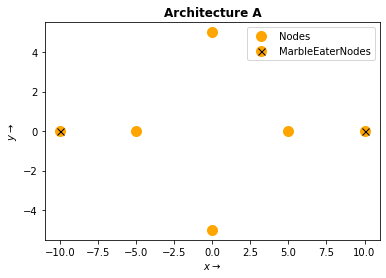

In [2]:
inputplacer_factory = (
    lambda input_pos, input_region_sizes :      
    ConstVelMassInputPlacer(input_pos, input_region_sizes,
                            torch.tensor([0.5, 0]))
)

CURRENT_ARCH = ARCHITECTURES.A
MODEL, INPUT_PLACER, EATERS = gen_architecture(CURRENT_ARCH, inputplacer_factory)
fig, ax = plot_model(MODEL)
ax.set_title(f"Architecture {CURRENT_ARCH.value}", weight="bold");
# fig.savefig(f"architecture_{CURRENT_ARCH.value}.pdf")

## Training setup

In [3]:
LOSS_POS_WEIGHT = 1
LOSS_VEL_WEIGHT = 1
DATASET = load_banknote_dataset()
BATCH_SIZE = 1
TRAINER, FILENAME_GEN = create_trainer(MODEL, 
                         INPUT_PLACER, 
                         EATERS,
                         DATASET,
                         loss_pos_weight= LOSS_POS_WEIGHT,
                         loss_vel_weight = LOSS_VEL_WEIGHT,
                         architecture = CURRENT_ARCH)

## Training loop

In [4]:
num_epochs = 40
step_size = 0.1
num_steps_till_read_output = int(2 / step_size)
do_validate = True
checkpoint_interval = 5

TRAINER.run_training(num_epochs,
                    step_size,
                    num_steps_till_read_output,
                    do_validate,
                    checkpoint_interval,
                    batch_size = BATCH_SIZE)

Finished epoch 0: loss = 81255.45048618317
Finished epoch 1: loss = 35243.31266152859
Finished epoch 2: loss = 17840.80849506706
Finished epoch 3: loss = 8234.731306512374
Epoch 4: saving model...
Model saved as /home/nifrec/Vault/Documents/bachelor_3/honors/nenwin/nenwin/banknote_dataset/checkpoints/BANKNOTE_A_Tue_May_25_16-09-06_2021_checkpoint.txt
Finished epoch 4: loss = 3155.416611976805
Finished epoch 5: loss = 1280.5822174690838
Finished epoch 6: loss = -1638.6742197140848
Finished epoch 7: loss = -11638.45292229834
Finished epoch 8: loss = -19301.043677339767
Epoch 9: saving model...
Model saved as /home/nifrec/Vault/Documents/bachelor_3/honors/nenwin/nenwin/banknote_dataset/checkpoints/BANKNOTE_A_Tue_May_25_16-09-06_2021_checkpoint.txt
Finished epoch 9: loss = -27140.68889475456
Finished epoch 10: loss = -1302.0991844132259
Finished epoch 11: loss = -1629.8379594758808
Finished epoch 12: loss = -3437.3206336428666
Finished epoch 13: loss = -10061.2015682954
Epoch 14: saving mo

In [5]:
stats = TRAINER.training_stats
filename = FILENAME_GEN.gen_filename()
filename = filename.replace(".txt", "_stats.pickle")
import pickle
with open(filename, "wb") as file:
    pickle.dump(stats, file)

Text(0, 0.5, 'Accuracy')

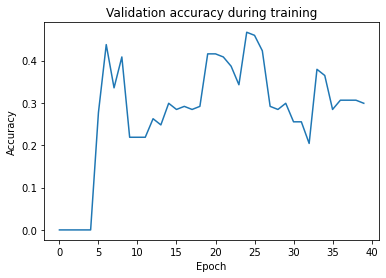

In [6]:
plt.plot(stats.validation_accuracies)
plt.title("Validation accuracy during training")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Loss')

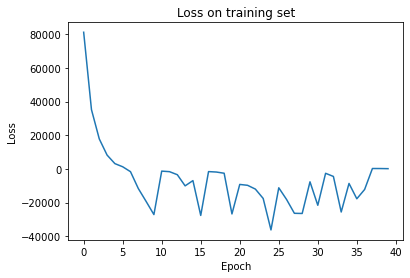

In [7]:
plt.plot(stats.train_losses, label="Training set")
plt.title("Loss on training set")
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [8]:
stats.validation_accuracies

(0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.2773722627737226,
 0.43795620437956206,
 0.3357664233576642,
 0.40875912408759124,
 0.21897810218978103,
 0.21897810218978103,
 0.21897810218978103,
 0.26277372262773724,
 0.24817518248175183,
 0.29927007299270075,
 0.2846715328467153,
 0.291970802919708,
 0.2846715328467153,
 0.291970802919708,
 0.41605839416058393,
 0.41605839416058393,
 0.40875912408759124,
 0.38686131386861317,
 0.34306569343065696,
 0.46715328467153283,
 0.45985401459854014,
 0.4233576642335766,
 0.291970802919708,
 0.2846715328467153,
 0.29927007299270075,
 0.25547445255474455,
 0.25547445255474455,
 0.20437956204379562,
 0.3795620437956204,
 0.36496350364963503,
 0.2846715328467153,
 0.30656934306569344,
 0.30656934306569344,
 0.30656934306569344,
 0.29927007299270075)

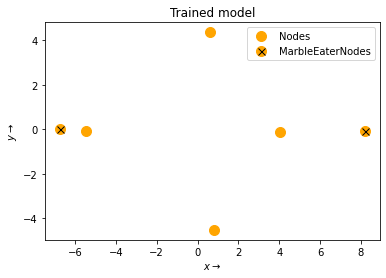

In [9]:
fig, ax = plot_model(MODEL)
ax.set_title("Trained model");

## Loading a saved model
To confirm the saving works. 
No point in training a model if it is lost immediately after!

In [12]:
filename = "/home/nifrec/Vault/Documents/bachelor_3/honors/nenwin/nenwin/banknote_dataset/checkpoints/BANKNOTE_A_Tue_May_25_16-09-06_2021.txt"
import torch.tensor as tensor
from nenwin.attraction_functions.attraction_functions import ThresholdGravity, NewtonianGravity
with open(filename, "r") as file:
    model = eval(file.readline())

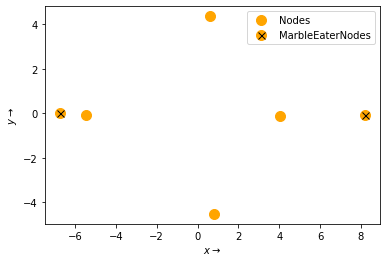

In [14]:
plot_model(model);